In [43]:
# bu sayfada fbprophet kütüphanesi ile bir sonraki gün için facebook üzerinden gelecek lead tahmini yaptık
import pandas as pd
import matplotlib.pyplot as plt
import fbprophet 

In [44]:
# library kurulun işlemleri
import fbprophet 

In [3]:
#veri setimizi çektik
import pandas as pd
transactions =pd.read_csv ("transactions.csv")
df = transactions.copy()

In [5]:
# ilk gözlmler
transactions.head(5)

,pk,ga_transactionid,ga_datehour,ga_products,ga_channels,ga_itemquantity
0,146288072,2_50414543,2020082900,Product D,Facebook,1
1,146288071,2_50414542,2020082900,Product D,Organic search,1
2,146287503,2_50413935,2020082900,Product D,Organic search,1
3,146287504,2_50413936,2020082900,Product D,Organic search,1
4,146296436,3_65496155,2020082900,Product E,Google Ads,1


In [6]:
#tarih düzeltme işlemleri yaptık
df['ga_datehour']=df['ga_datehour'] // 100

In [7]:
df['ga_datehour'] = pd.to_datetime(df['ga_datehour'], format='%Y%m%d')

In [8]:
df. head (2)

,pk,ga_transactionid,ga_datehour,ga_products,ga_channels,ga_itemquantity
0,146288072,2_50414543,2020-08-29,Product D,Facebook,1
1,146288071,2_50414542,2020-08-29,Product D,Organic search,1


In [10]:
# günlük facebook lead sayılarını toplamak için pivot table oluşturduk içinden sadece fbprophet kütüphanesi istediği için 
# tarih ve lead itemquantity sayılarını gruplayıp derledik , ayrıca "ds" ile "y"  şeklinde yeniden isimlendirdik
import numpy as np
pivotdf =pd.pivot_table(df, values='ga_itemquantity', index=['ga_channels'], columns=["ga_datehour"], aggfunc=np.size)

In [11]:
df1 =df.loc [(df.ga_channels == "Facebook"),["ga_datehour","ga_itemquantity"]]
       

In [14]:
df1.head (2)

,ga_datehour,ga_itemquantity
0,2020-08-29,1
19,2020-08-29,1


In [18]:
pivotdf1 =pd.pivot_table(df1, values='ga_itemquantity', index=["ga_datehour"], aggfunc=np.size)

In [25]:
pivotdf1 = pivotdf1.reset_index()

In [27]:
pivotdf1 = pivotdf1.rename(columns={'ga_datehour': 'ds', 'y': 'y'})

In [28]:
# pivot table derleme işlemleri tamamlandı
pivotdf1

,ds,y
0,2020-08-29,2123
1,2020-08-30,2810
2,2020-08-31,2919
3,2020-09-01,2546
4,2020-09-02,3063
...,...,...
411,2021-10-14,4928
412,2021-10-15,4327
413,2021-10-16,4290
414,2021-10-17,6518


In [45]:
# item flow tablosu oluşturduk
# leadler üzerinde belirgin bir mevsimsellik gözlenmektedir.
pivotdf1 = pivotdf1.sort_values(by=['ds'],ascending=True)

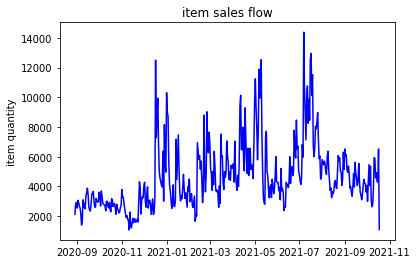

In [46]:
plt.plot(pivotdf1['ds'],pivotdf1['y'],'b') # mavi renk
plt.title('item sales flow')
plt.ylabel('item quantity')
plt.draw()

In [47]:
# modeli çalıştırmak için gerekli kurulum işlemleri
from fbprophet import Prophet

In [62]:
df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
df_prophet.fit(pivotdf1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\HuseyinBurakBolat\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [63]:
# önümüzdeki 1 yıl için tahmin aldık ve grafik oluşturduk ancak daha sonra bir sonraki günün tahminini seçeceğiz
pred_period=365
df_forecast = df_prophet.make_future_dataframe(periods= pred_period, freq='D')
df_forecast = df_prophet.predict(df_forecast)

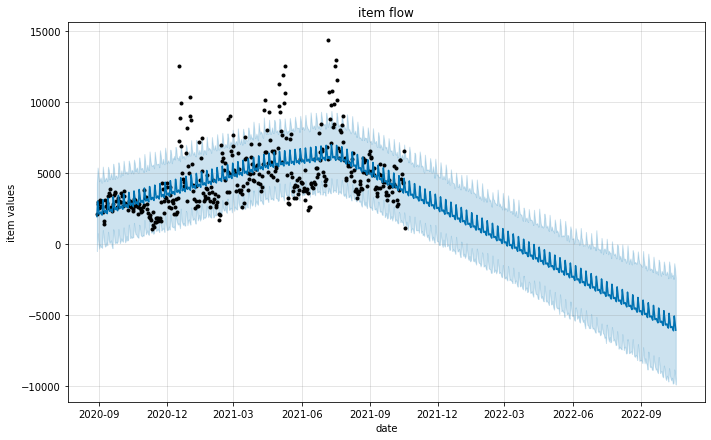

In [64]:
df_prophet.plot(df_forecast, xlabel = 'date', ylabel = "item_count")
plt.title(f'{pred_period} predicts')
plt.title('item flow')
plt.ylabel('item values')
 
plt.show()

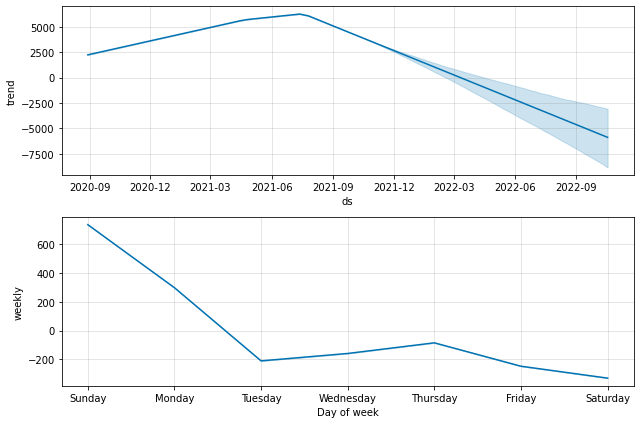

In [65]:
df_prophet.plot_components(df_forecast)
plt.show()

In [70]:
# sonuç olarak elimizdeki veri setindeki son gün olan 2021-10-18 'den sonraki ilk günün tahminini aldık
# diğer dosyada transaction için heat map analizi yapmıştık.
# orada görüldüğü gibi tahmin modelimiz low season trend etkisi ile düşüş eğilimi gösteren bir lead tahmini oluşturmuştur.
df_forecast [df_forecast.ds == "2021-10-19" ]


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
416,2021-10-19,3821.568358,1152.404416,6053.719069,3821.568358,3821.568358,-210.970535,-210.970535,-210.970535,-210.970535,-210.970535,-210.970535,0.0,0.0,0.0,3610.597823
